In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
from torch.autograd import Variable

In [2]:
class LSTM(nn.Module):
    def __init__(self, in_no, hid_no, layer_no, device):
        super(LSTM, self).__init__()
        
        self.in_no = in_no
        self.hid_no = hid_no
        self.layer_no = layer_no
        self.device = device
        
        self.lstm = nn.LSTM(self.in_no, self.hid_no, self.layer_no, batch_first=True)
        self.linear = nn.Linear(self.hid_no, 1)
        
        self.Tau = nn.Parameter(torch.ones(self.in_no)*(2.5) , requires_grad=False)
        self.step = Step.apply
        
        self.Tau_spk = nn.Parameter(torch.ones(1)*2 , requires_grad=False)
        self.W_spk = nn.Parameter(torch.ones(1)*0.5 , requires_grad=False)
        
    def forward(self, S):
        T_data = S.shape[0]
        
        t = torch.arange(201).reshape(1,-1).repeat(self.in_no,1).to(self.device)
        t_tau = t / torch.exp(self.Tau).reshape(-1,1)
        kern = t_tau * torch.exp(-t_tau)
        kern = torch.flip(kern, [0]).unsqueeze(1)
        
        S_conv = F.conv1d(S.T.unsqueeze(0), kern, padding=100, groups=self.in_no).squeeze(0).T
        
        input = S_conv.unsqueeze(1)
        raw_out, _ = self.lstm(input)
        out = self.linear(raw_out.squeeze(1)).flatten()
        out = self.step(out)
        
        t_spk = torch.arange(201).to(self.device)
        t_tau_spk = t_spk / torch.exp(self.Tau_spk)
        kern_spk = t_tau_spk * torch.exp(-t_tau_spk) * torch.exp(self.W_spk)
        kern_spk = torch.flip(kern_spk, [0])
        V = F.conv1d(out.reshape(1,1,-1), kern_spk.reshape(1,1,-1), padding=100).flatten()
        
        return V
    
class Step(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        zero = torch.tensor([0.0]).cuda()
        return torch.heaviside(input, zero)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        derivative = 1/(1+torch.abs(input))**2
        output = derivative * grad_input
        return output

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
V_file = "V_diff.npy"

C_syn_e = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub5_C_syn_e.npy")
C_syn_e = torch.from_numpy(C_syn_e)[1:]

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)[:,:]
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)

E_neural = torch.from_numpy(E_neural)
E_neural = torch.matmul(E_neural, C_syn_e.T)

V = torch.from_numpy(V)
#####
V[V < 0.3] = 0

In [4]:
T_train = 8 * 1000 * 50
T_test = 1 * 1000 * 50
device = torch.device("cuda")
hid_no = 5
layer_no = 3
in_no = 4

batch_size = 50000
iter_no = 10000
epoch_no = iter_no*batch_size//T_train 


In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()

part_V_train = V_train[:50000].to(device)
part_train_E_neural = train_E_neural[:50000].to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = LSTM(in_no, hid_no, layer_no, device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

706


In [7]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred = model(batch_E_neural)
        
    mse = torch.mean((V_pred - batch_V)**2)
    var = torch.var(V_pred - batch_V)
    
    reg2 = 0
    reg1 = 0
    for param in model.parameters():
        reg2 += torch.sum(param**2)
        reg1 += torch.sum(torch.abs(param))
    
    loss = mse
    
    loss.backward()
    optimizer.step()
    
    if i%100 == 99:
        model.eval()
        test_V_pred = model(test_E_neural) 
        train_V_pred = model(part_train_E_neural)
         
        test_mse = torch.mean((test_V_pred - V_test)**2).item()
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        
        train_mse = torch.mean((train_V_pred - part_V_train)**2).item()
        train_score = explained_variance_score(part_V_train.cpu().detach().numpy(), train_V_pred.cpu().detach().numpy())
        
        tau_avg = torch.mean(model.Tau).item()
        
        print(i, np.round(test_score, 6),
              np.round(test_mse, 6),
              np.round(train_score, 6),
              np.round(train_mse, 6),
              np.round(tau_avg, 6)
             )


<ipython-input-7-0985bc6359c3>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


99 0.0 0.021871 0.0 0.029317 2.5
199 0.0 0.021871 0.0 0.029317 2.5
299 0.0 0.021871 0.0 0.029317 2.5
399 0.0 0.021871 0.0 0.029317 2.5
499 0.0 0.021871 0.0 0.029317 2.5
599 -3.351673 0.093175 -2.280494 0.094399 2.5
699 -16.135733 0.367553 -7.941401 0.257159 2.5
799 0.0 0.021871 0.0 0.029317 2.5
899 -9.292045 0.220406 -5.996775 0.20109 2.5
999 0.0 0.021871 0.0 0.029317 2.5
1099 0.0 0.021871 0.0 0.029317 2.5
1199 0.0 0.021871 0.0 0.029317 2.5
1299 0.0 0.021871 -0.275827 0.037072 2.5
1399 0.0 0.021871 0.0 0.029317 2.5
1499 -32.052242 0.71184 -23.766718 0.71517 2.5
1599 0.0 0.021871 0.0 0.029317 2.5
1699 0.0 0.021871 0.0 0.029317 2.5
1799 0.0 0.021871 0.0 0.029317 2.5
1899 0.0 0.021871 0.0 0.029317 2.5
1999 0.0 0.021871 0.0 0.029317 2.5
2099 0.0 0.021871 0.0 0.029317 2.5
2199 0.0 0.021871 0.0 0.029317 2.5
2299 -8.559743 0.204542 -8.646407 0.277455 2.5
2399 0.0 0.021871 0.0 0.029317 2.5
2499 0.0 0.021871 0.0 0.029317 2.5
2599 0.0 0.021871 0.0 0.029317 2.5
2699 0.0 0.021871 0.0 0.029317 2.5


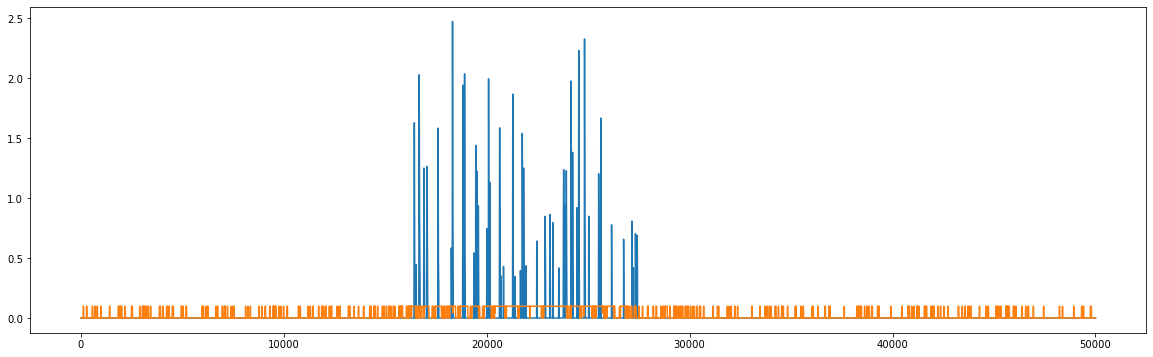

In [8]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.cpu().detach().numpy())


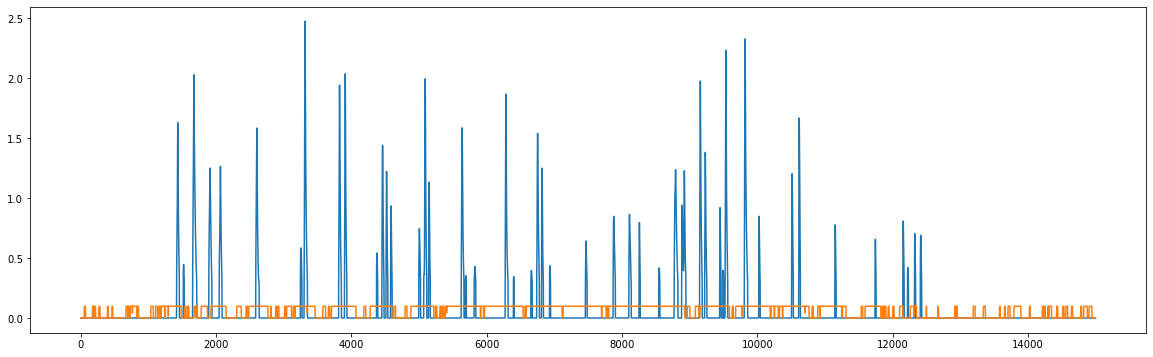

In [9]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[15000:30000])
plt.plot(test_V_pred.cpu().detach().numpy()[15000:30000])


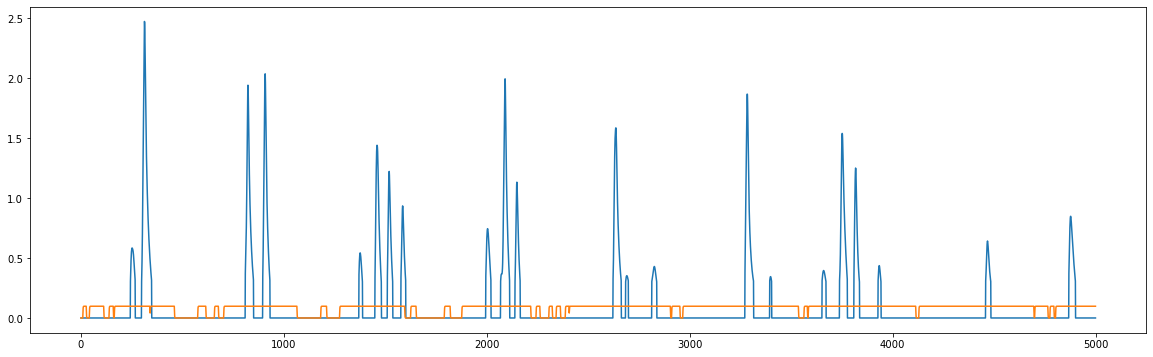

In [10]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[15000:30000][3000:8000])
plt.plot(test_V_pred.cpu().detach().numpy()[15000:30000][3000:8000])
